<a href="https://colab.research.google.com/github/mk0653/untitled/blob/master/Accident%20type%20classification/Accident_type_classification_ipynb_V2_Albert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import sys
import re

from google.colab import drive
drive.mount('/gdrive')


Mounted at /gdrive


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install transformers

     |████████████████████████████████| 2.9 MB 7.6 MB/s 
     |████████████████████████████████| 596 kB 68.8 MB/s 
     |████████████████████████████████| 3.3 MB 54.5 MB/s 
     |████████████████████████████████| 895 kB 43.9 MB/s 
     |████████████████████████████████| 56 kB 6.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [5]:
!pip install spacy

In [6]:
!pip install japanize-matplotlib

     |████████████████████████████████| 4.1 MB 7.5 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120274 sha256=9a1d84a9250596f163b3997a67092bf7a5feb35cde7702ea00c9782a47fe1cdf
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib


In [7]:
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 8.0 MB/s 


In [8]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

import os
import re
import json
import glob
from collections import defaultdict
from textblob import TextBlob
from functools import partial

import pandas as pd
import numpy as np

import torch
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import japanize_matplotlib 
import random

import nltk
import spacy
from nltk.probability import FreqDist
from wordcloud import WordCloud, STOPWORDS

from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
from transformers import BertTokenizerFast, BertForSequenceClassification,RobertaTokenizerFast,RobertaForSequenceClassification,T5TokenizerFast, AutoModelForSequenceClassification,AlbertTokenizerFast, AlbertForSequenceClassification
from transformers import Trainer, TrainingArguments
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
from tqdm.autonotebook import tqdm
import string

%matplotlib inline

厚生労働省　職場の安全ガイドより死亡災害DBの情報を取得。

https://anzeninfo.mhlw.go.jp/anzen_pg/SIB_FND.aspx

ひとまず平成30年～15年の16年分のデータで試してみる。

In [9]:
train_df = pd.read_csv('/content/drive/MyDrive/事故の型分類/sibou_db_h30_15.csv')
train_df_clean = pd.read_csv('/content/drive/MyDrive/事故の型分類/sibou_db_h30_15_label.csv')
#add_train =  pd.read_csv('/content/drive/MyDrive/事故の型分類/sisyou_db_h29_01-12_label.csv')
add_train =  pd.read_csv('/content/drive/MyDrive/事故の型分類/sibou_db_h14-5_label.csv')

In [10]:
train_df.head

<bound method NDFrame.head of          ID   月 発生\n時間  ... 業種(小分類)コード     業種(小分類)        事故の型
0         1  12  14～15  ...      10109  その他の食料品製造業  はさまれ、巻き込まれ
1         2  12  21～22  ...      40201  ハイヤー・タクシー業    交通事故（道路）
2         3  12  16～17  ...      40101      鉄道・軌道業       墜落、転落
3         4  12  10～11  ...      30202   木造家屋建築工事業       墜落、転落
4         5  12  12～13  ...     150101   ビルメンテナンス業       墜落、転落
...     ...  ..    ...  ...        ...         ...         ...
19111  1624  12  11～12  ...        418     建築物、構築物         おぼれ
19112  1625  12  13～14  ...        418     建築物、構築物       墜落、転落
19113  1626  12    4～5  ...        221        トラック    交通事故（道路）
19114  1627  12  14～15  ...        231  乗用車、バス、バイク    交通事故（道路）
19115  1628  12   9～10  ...        221        トラック       墜落、転落

[19116 rows x 11 columns]>

In [11]:
train_df_clean.head(6)

,label,sentence
0,7,災害発生現場において、元請事業場の労働者２名がＡタンク内の飼料の清掃作業に従事していた。Ａタ...
1,17,国道沿いにある飲食店の駐車場から下り三車線を横切って上り線に右折しようとしていたタクシーと、...
2,1,同日、駅に入線する８名（本）の電車の運転士に対し、実設訓練を行っていた。被災者は２本目の電車...
3,1,木造２階建新築住宅建設において、前日の基礎コンクリート打設作業に続き、モルタルの敷均しを行う...
4,1,マンションの清掃業務終了後、共用棟内のロッカー室において、地下へ通じる階段下に被災者が倒れて...
5,17,現場で負傷した労働者を乗せた救急車が、自動車道を走行中、道を譲ったトラックを追い越す際、路肩...


In [12]:
add_train

,label,sentence
0,7,コンクリート2次製品（ケーブル用ボックス）の鋼製型枠調整のため、Ｌ型の側板（454ｋｇ）を取...
1,17,走行中のタクシーが、橋上の凍結部分でスリップして歩道に乗り上げ、橋の欄干を突き破って約10m...
2,17,走行中のタクシーが、橋上の凍結部分でスリップして歩道に乗り上げ、橋の欄干を突き破って約10m...
3,10,埠頭にある船舶誘導用の導灯点検中、第2号導灯の不点灯があったので予備灯に切り換える作業を行い...
4,4,トラック運転手として、材木（輸入材の束、１束、長さ3.68ｍの板を96本、約1.1ｔ）をトラ...
...,...,...
18516,2,フォークリフトで構内を走行中、フォークリフトが転倒した。
18517,7,マシニングセンターの歯車加工工程において、加工中のドリル付近で加工済穴の測定を行っていたとこ...
18518,7,構内において積み上げた古紙にビニルシートを掛けていたところ、後進してきたフォークリフトと古紙...
18519,17,バイクで郵便配達中、町道交差点でトラックと衝突した。


In [13]:
print(train_df_clean)

       label                                           sentence
0          7  災害発生現場において、元請事業場の労働者２名がＡタンク内の飼料の清掃作業に従事していた。Ａタ...
1         17  国道沿いにある飲食店の駐車場から下り三車線を横切って上り線に右折しようとしていたタクシーと、...
2          1  同日、駅に入線する８名（本）の電車の運転士に対し、実設訓練を行っていた。被災者は２本目の電車...
3          1  木造２階建新築住宅建設において、前日の基礎コンクリート打設作業に続き、モルタルの敷均しを行う...
4          1  マンションの清掃業務終了後、共用棟内のロッカー室において、地下へ通じる階段下に被災者が倒れて...
...      ...                                                ...
19111     10  事業場の駐車場脇の生コン車洗浄用水等の浄化沈殿槽内でコンビニで昼食を買った被災者が近道をする...
19112      1  エレベーターの昇降路塔の上部で、校舎の「ひさし」を解体したときの「コンクリートがら」を地上に...
19113     17  10tトラックで国道を走行中、信号待ちで停車しようとしていた前方の大型トレーラーの後部に気付...
19114     17  中国上海へ出張し、取引先の労働者が運転する乗用車に同乗して取引先に向かって高速道路を走行中、...
19115      1  パワーゲート付き4tトラックで荷物を搬入し、パワーゲート上（高さ地上より約106cm）にパレ...

[19116 rows x 2 columns]


In [14]:
train_df_clean = pd.concat([train_df_clean, add_train])

In [15]:
train_df_clean

,label,sentence
0,7,災害発生現場において、元請事業場の労働者２名がＡタンク内の飼料の清掃作業に従事していた。Ａタ...
1,17,国道沿いにある飲食店の駐車場から下り三車線を横切って上り線に右折しようとしていたタクシーと、...
2,1,同日、駅に入線する８名（本）の電車の運転士に対し、実設訓練を行っていた。被災者は２本目の電車...
3,1,木造２階建新築住宅建設において、前日の基礎コンクリート打設作業に続き、モルタルの敷均しを行う...
4,1,マンションの清掃業務終了後、共用棟内のロッカー室において、地下へ通じる階段下に被災者が倒れて...
...,...,...
18516,2,フォークリフトで構内を走行中、フォークリフトが転倒した。
18517,7,マシニングセンターの歯車加工工程において、加工中のドリル付近で加工済穴の測定を行っていたとこ...
18518,7,構内において積み上げた古紙にビニルシートを掛けていたところ、後進してきたフォークリフトと古紙...
18519,17,バイクで郵便配達中、町道交差点でトラックと衝突した。


In [16]:
train_df_clean = train_df_clean.astype(str)

テキストの件数と事故の型の件数を確認してみる。事故の型は定義されているものが全部で22種類のため、必要な分類パターンはありそう

In [17]:
train_df['事故の型'] = train_df['事故の型'].replace('高温、低温の物との接触', '高温・低温の物との接触').replace('墜落・転落', '墜落、転落').replace('動作の反動無理な動作', '動作の反動、無理な動作').replace('飛来・落下', '飛来、落下').replace('有害物との接触', '有害物等との接触').replace('交通事故(道路)', '交通事故（道路）')

In [18]:
print(len(train_df['災害状況'].unique()))
print(len(train_df['事故の型'].unique()))

18740
22


In [19]:
train_df_clean = train_df_clean.replace('90', '20')
train_df_clean = train_df_clean.replace('99', '21')
train_df_clean["label"] = train_df_clean["label"].astype(np.int64) -1

In [20]:
train_df_clean

,label,sentence
0,6,災害発生現場において、元請事業場の労働者２名がＡタンク内の飼料の清掃作業に従事していた。Ａタ...
1,16,国道沿いにある飲食店の駐車場から下り三車線を横切って上り線に右折しようとしていたタクシーと、...
2,0,同日、駅に入線する８名（本）の電車の運転士に対し、実設訓練を行っていた。被災者は２本目の電車...
3,0,木造２階建新築住宅建設において、前日の基礎コンクリート打設作業に続き、モルタルの敷均しを行う...
4,0,マンションの清掃業務終了後、共用棟内のロッカー室において、地下へ通じる階段下に被災者が倒れて...
...,...,...
18516,1,フォークリフトで構内を走行中、フォークリフトが転倒した。
18517,6,マシニングセンターの歯車加工工程において、加工中のドリル付近で加工済穴の測定を行っていたとこ...
18518,6,構内において積み上げた古紙にビニルシートを掛けていたところ、後進してきたフォークリフトと古紙...
18519,16,バイクで郵便配達中、町道交差点でトラックと衝突した。


In [21]:
num = len(train_df_clean)
train_df_clean[:int(num*0.8)].to_csv('/content/drive/MyDrive/事故の型分類/train.csv', sep=',', index=False)
train_df_clean[int(num*0.8):].to_csv('/content/drive/MyDrive/事故の型分類/dev.csv', sep=',', index=False)

In [22]:
words =list( train_df['事故の型'].values)
split_words=[]
for word in words:
    lo_w=[]
    list_of_words=str(word).split()
    for w in list_of_words:
        lo_w.append(w)
    split_words.append(lo_w)
allwords = []
for wordlist in split_words:
    allwords += wordlist

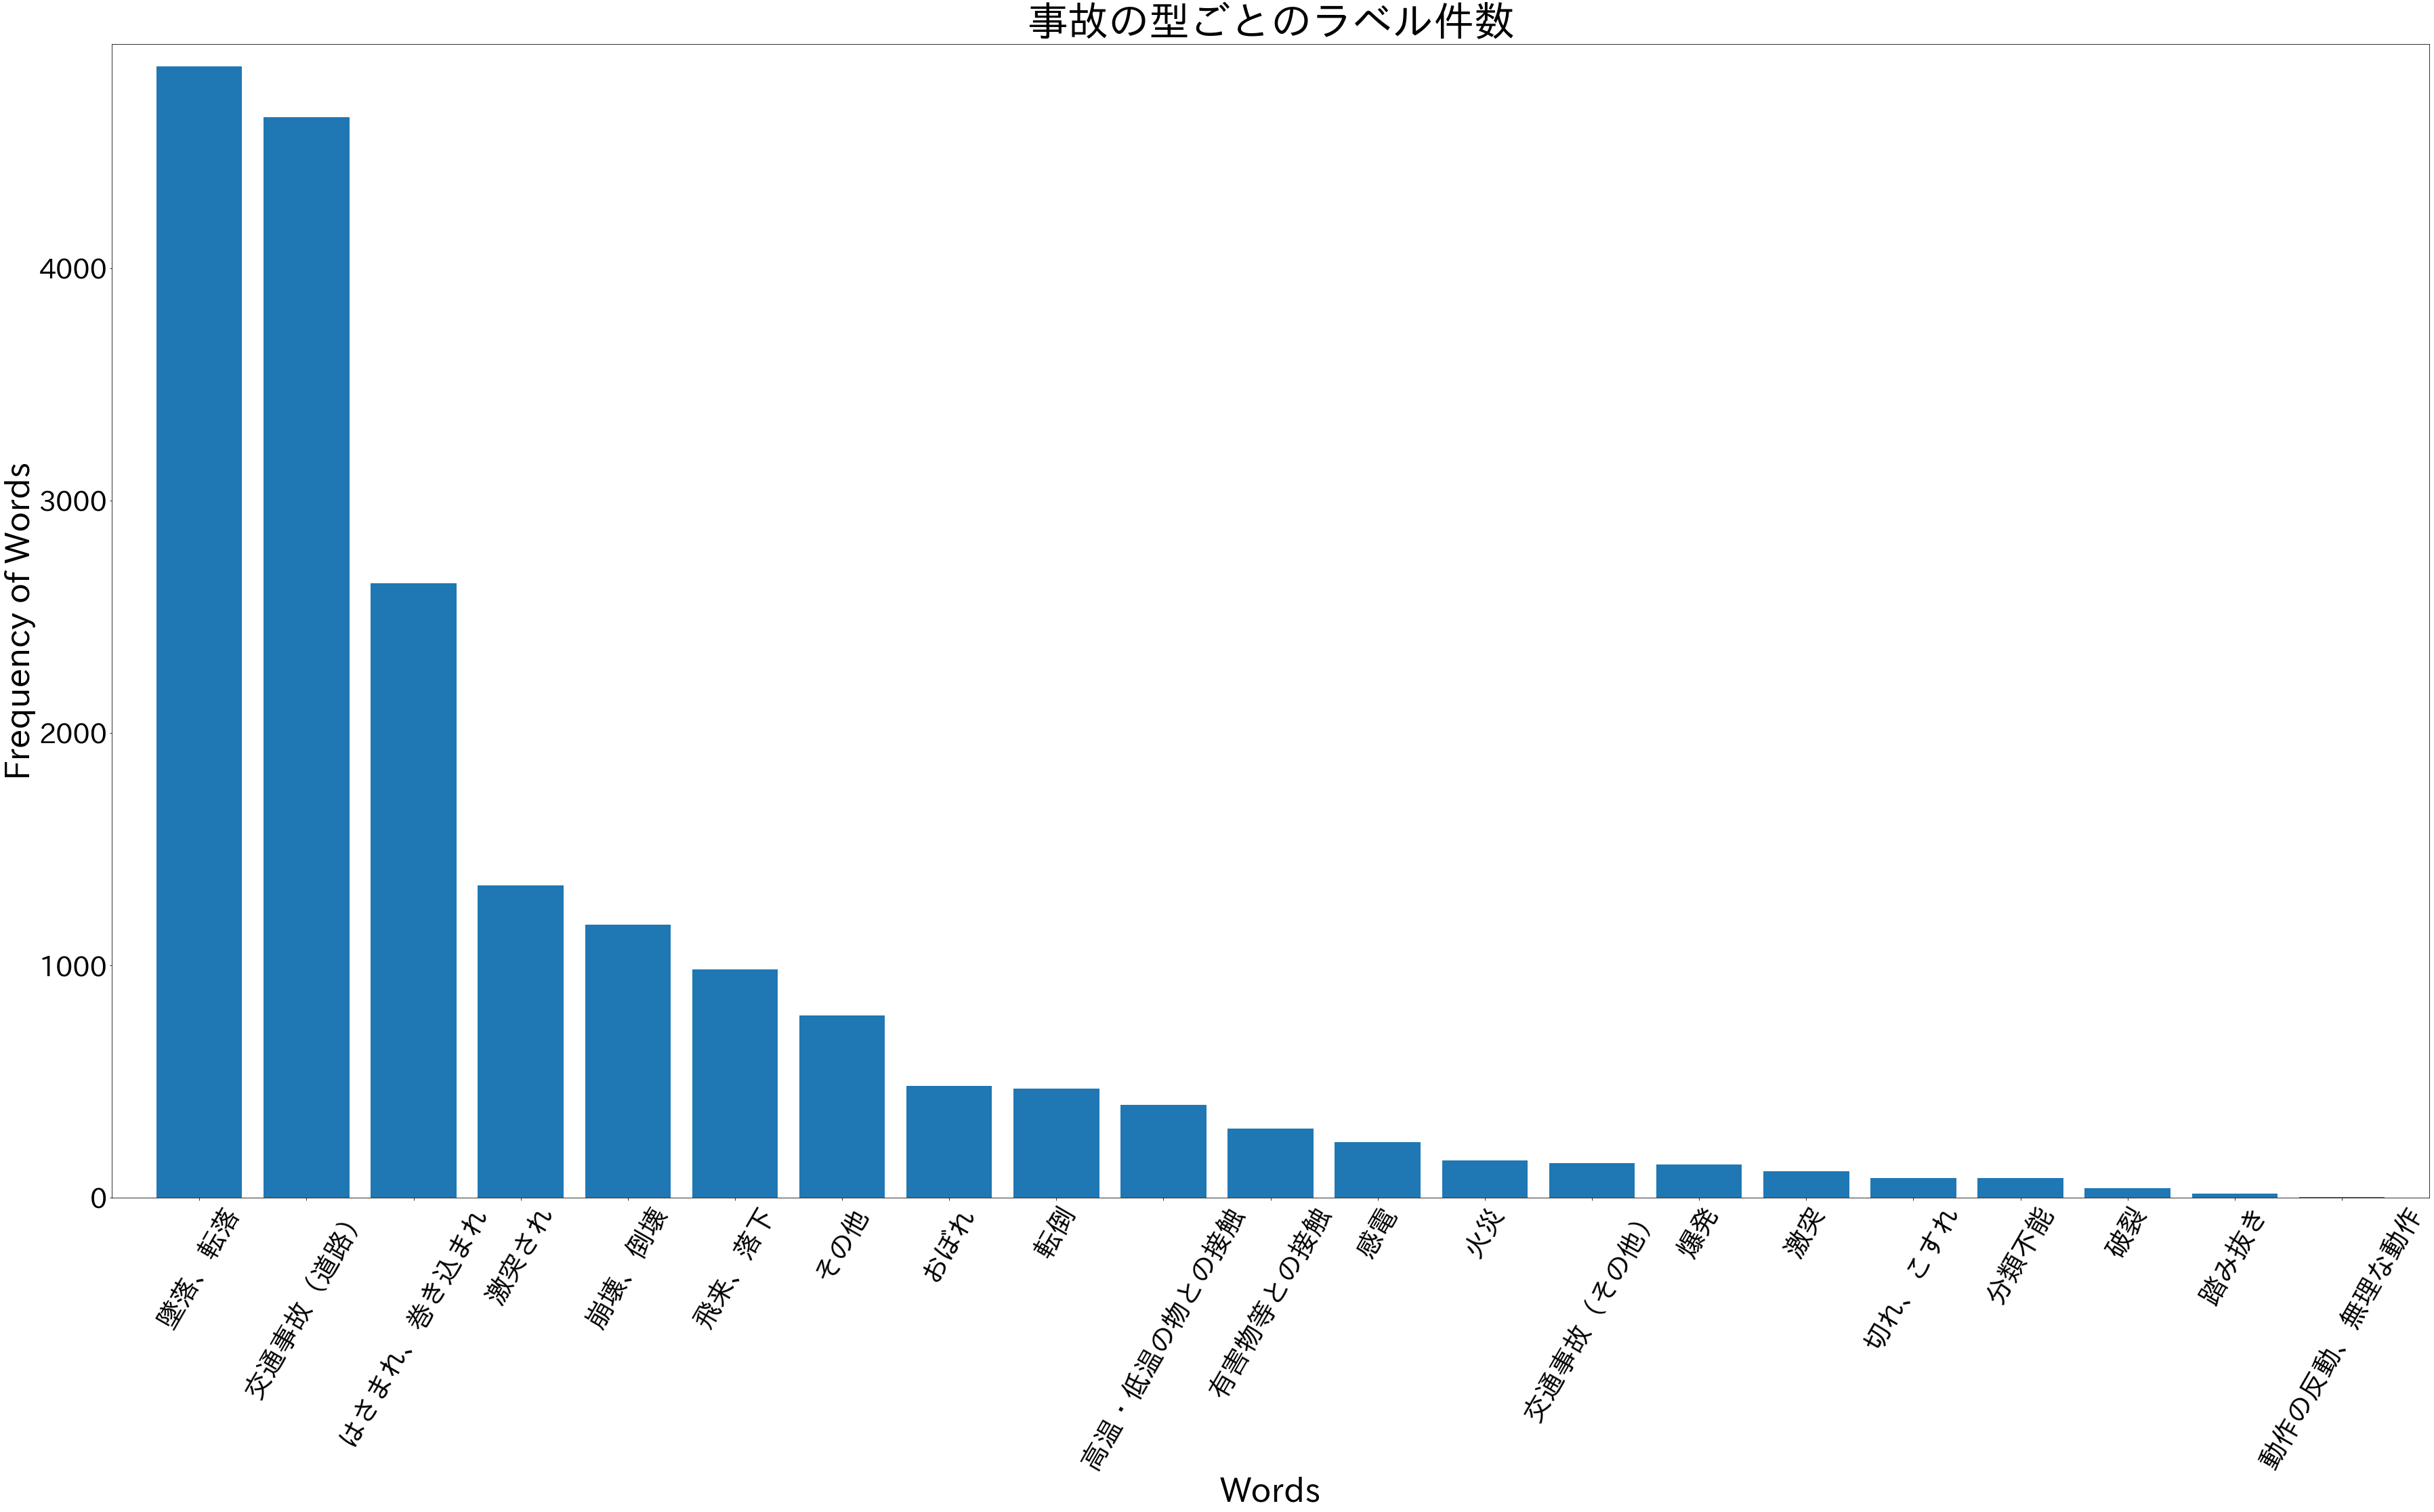

In [23]:
mostcommon_small = FreqDist(allwords).most_common(21)
x, y = zip(*mostcommon_small)
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.tight_layout(pad=0)
plt.title('事故の型ごとのラベル件数', fontsize=60)
plt.show()

ここからが学習データでのファインチューニングを行う。

In [24]:
!pip install fugashi[unidic-lite]
!pip install ipadic

     |████████████████████████████████| 490 kB 7.5 MB/s 
     |████████████████████████████████| 47.4 MB 66 kB/s 
  Created wheel for unidic-lite: filename=unidic_lite-1.0.8-py3-none-any.whl size=47658836 sha256=95584a27b100a995262c6a6659c1edd55e2655e82a30a0d93a348dde4919c83c
  Stored in directory: /root/.cache/pip/wheels/de/69/b1/112140b599f2b13f609d485a99e357ba68df194d2079c5b1a2
Successfully built unidic-lite
     |████████████████████████████████| 13.4 MB 7.0 MB/s 
  Created wheel for ipadic: filename=ipadic-1.0.0-py3-none-any.whl size=13556723 sha256=a678e9c4cd6db2fffe37b4ff8598c64de6e86234f3a65e02efdfe37d856efce1
  Stored in directory: /root/.cache/pip/wheels/33/8b/99/cf0d27191876637cd3639a560f93aa982d7855ce826c94348b
Successfully built ipadic


In [25]:
# Huggingface Datasetsのインストール
!pip install datasets

     |████████████████████████████████| 287 kB 7.3 MB/s 
     |████████████████████████████████| 243 kB 61.4 MB/s 
     |████████████████████████████████| 1.3 MB 53.5 MB/s 
     |████████████████████████████████| 125 kB 71.7 MB/s 
     |████████████████████████████████| 160 kB 69.7 MB/s 
     |████████████████████████████████| 271 kB 67.0 MB/s 


###サンプルでの学習から変更

In [26]:
!nvidia-smi

Fri Oct 15 03:06:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

シード値から生成される乱数の固定化

In [27]:
def set_seed(seed: int):
    """
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
    installed).

    Args:
        seed (:obj:`int`): The seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    if is_torch_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # ^^ safe to call this function even if cuda is not available
    if is_tf_available():
        import tensorflow as tf

        tf.random.set_seed(seed)

set_seed(1)

In [28]:
train = pd.read_csv("/content/drive/MyDrive/事故の型分類/train.csv")
valid =pd.read_csv("/content/drive/MyDrive/事故の型分類/dev.csv")

In [29]:
train

,label,sentence
0,6,災害発生現場において、元請事業場の労働者２名がＡタンク内の飼料の清掃作業に従事していた。Ａタ...
1,16,国道沿いにある飲食店の駐車場から下り三車線を横切って上り線に右折しようとしていたタクシーと、...
2,0,同日、駅に入線する８名（本）の電車の運転士に対し、実設訓練を行っていた。被災者は２本目の電車...
3,0,木造２階建新築住宅建設において、前日の基礎コンクリート打設作業に続き、モルタルの敷均しを行う...
4,0,マンションの清掃業務終了後、共用棟内のロッカー室において、地下へ通じる階段下に被災者が倒れて...
...,...,...
30104,0,事業場内の階段を降りる途中、踊り場に転落した。
30105,0,広場の鋸歯状屋根のステンレス谷樋とアルミ枠継ぎ目のシーリング作業中、谷樋上でバランスを崩し、...
30106,9,発電機の水車の羽根とケーシングの隙間を測定するため、ケーシング内にチェーンで吊り足場を設置中...
30107,4,橋形クレーンでＬ型擁壁を整理中、擁壁をクレーン脚部付近に降ろし、次の荷役のためクレーンを動か...


データの前処理を実施

In [30]:
train_texts = train["sentence"].tolist()
valid_texts = valid["sentence"].tolist()
train_labels = train["label"].tolist()
valid_labels = valid["label"].tolist()

In [31]:
import re
import os
import urllib.request
import unicodedata
import nltk

from bs4 import BeautifulSoup
from collections import Counter
from gensim import corpora
from nltk.corpus import wordnet

#記号の除去
def clean_text(text):
    replaced_text = text.lower()
    replaced_text = re.sub(r'[【】]', ' ', replaced_text)       # 【】の除去
    replaced_text = re.sub(r'[（）()]', ' ', replaced_text)     # （）の除去
    replaced_text = re.sub(r'[［］\[\]]', ' ', replaced_text)   # ［］の除去
    replaced_text = re.sub(r'[@＠]\w+', '', replaced_text)  # メンションの除去
    replaced_text = re.sub(
        r'https?:\/\/.*?[\r\n ]', '', replaced_text)  # URLの除去
    replaced_text = re.sub(r'　', ' ', replaced_text)  # 全角空白の除去
    return replaced_text

#文字種統一、正規化
def normalize(text):
    normalized_text = normalize_unicode(text)
    normalized_text = normalize_number(normalized_text)
    normalized_text = lower_text(normalized_text)
    return normalized_text


def lower_text(text):
    return text.lower()


def normalize_unicode(text, form='NFKC'):
    normalized_text = unicodedata.normalize(form, text)
    return normalized_text


def lemmatize_term(term, pos=None):
    if pos is None:
        synsets = wordnet.synsets(term)
        if not synsets:
            return term
        pos = synsets[0].pos()
        if pos == wordnet.ADJ_SAT:
            pos = wordnet.ADJ
    return nltk.WordNetLemmatizer().lemmatize(term, pos=pos)


def normalize_number(text):
    """
    pattern = r'\d+'
    replacer = re.compile(pattern)
    result = replacer.sub('0', text)
    """
    # 連続した数字を0で置換
    replaced_text = re.sub(r'\d+', '0', text)
    return replaced_text


#ストップワード除去
def maybe_download(path):
    url = 'http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt'
    if os.path.exists(path):
        print('File already exists.')
    else:
        print('Downloading...')
        # Download the file from `url` and save it locally under `file_name`:
        urllib.request.urlretrieve(url, path)


def create_dictionary(texts):
    dictionary = corpora.Dictionary(texts)
    return dictionary


def remove_stopwords(words, stopwords):
    words = [word for word in words if word not in stopwords]
    return words


def most_common(docs, n=100):
    fdist = Counter()
    for doc in docs:
        for word in doc:
            fdist[word] += 1
    common_words = {word for word, freq in fdist.most_common(n)}
    print('{}/{}'.format(n, len(fdist)))
    return common_words


def get_stop_words(docs, n=100, min_freq=1):
    fdist = Counter()
    for doc in docs:
        for word in doc:
            fdist[word] += 1
    common_words = {word for word, freq in fdist.most_common(n)}
    rare_words = {word for word, freq in fdist.items() if freq <= min_freq}
    stopwords = common_words.union(rare_words)
    print('{}/{}'.format(len(stopwords), len(fdist)))
    return stopwords

In [32]:
train_texts_clean = []
valid_texts_clean = []
for x in tqdm(range(len(train_texts))):
  train_texts_clean.append(clean_text(train_texts[x]))

for x in tqdm(range(len(valid_texts))):
  valid_texts_clean.append(clean_text(valid_texts[x]))

train_texts = train_texts_clean
valid_texts = valid_texts_clean 

  0%|          | 0/30109 [00:00<?, ?it/s]

  0%|          | 0/7528 [00:00<?, ?it/s]

In [33]:
# the model we gonna train, base uncased BERT
# check text classification models here: https://huggingface.co/models?filter=text-classification
model_name = "ALINEAR/albert-japanese-v2"
# max sequence length for each document/sentence sample
max_length = 256

#tokenizer = BertTokenizerFast.from_pretrained(model_name, do_lower_case=True)
tokenizer = AlbertTokenizerFast.from_pretrained("/content/drive/MyDrive/albert-base", do_lower_case=True)

# tokenize the dataset, truncate when passed `max_length`, 
# and pad with 0's when less than `max_length`
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length)
valid_encodings = tokenizer(valid_texts, truncation=True, padding=True, max_length=max_length)

In [34]:
class NewsGroupsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)

# convert our tokenized data into a torch Dataset
train_dataset = NewsGroupsDataset(train_encodings, train_labels)
valid_dataset = NewsGroupsDataset(valid_encodings, valid_labels)

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [36]:
from sklearn.metrics import accuracy_score,fbeta_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  # calculate accuracy using sklearn's function
  #acc = accuracy_score(labels, preds)
  fbeta = fbeta_score(labels, preds,average='micro', beta=0.5)
  return {
      'micro_mean': fbeta,
  }

In [37]:
train['label'].nunique()

21

In [38]:
valid['label'].nunique()

20

In [39]:
# load the model and pass to CUDA
#model = BertForSequenceClassification.from_pretrained(model_name, num_labels=train['label'].nunique()).to(device)
model = AlbertForSequenceClassification.from_pretrained("/content/drive/MyDrive/albert-base", num_labels=train['label'].nunique()).to(device)

Some weights of the model checkpoint at /content/drive/MyDrive/albert-base were not used when initializing AlbertForSequenceClassification: ['predictions.dense.weight', 'predictions.decoder.weight', 'predictions.LayerNorm.weight', 'predictions.dense.bias', 'predictions.LayerNorm.bias', 'predictions.decoder.bias', 'predictions.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/albert-base and are newly initialized: ['albert

In [40]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=4,              # total number of training epochs
    learning_rate = 2e-5,
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=100,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    load_best_model_at_end=True,     # load the best model when finished training (default metric is loss)
    # but you can specify `metric_for_best_model` argument to change to accuracy or other metric
    logging_steps=250,               # log & save weights each logging_steps
    evaluation_strategy="steps",     # evaluate each `logging_steps`
)

In [41]:
from torch import nn
from transformers import Trainer

class MultilabelTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get('logits')
        loss_fct = nn.BCEWithLogitsLoss()
        loss = loss_fct(logits.view(-1, self.model.config.num_labels),
                        labels.float().view(-1, self.model.config.num_labels))
        return (loss, outputs) if return_outputs else loss

In [42]:
trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=valid_dataset,          # evaluation dataset
    compute_metrics=compute_metrics,     # the callback that computes metrics of interest
)

In [43]:
!nvidia-smi

Fri Oct 15 03:06:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    33W / 250W |   1137MiB / 16280MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

学習の実行。データのうち8割を学習データ。残りの2割を評価用データとした。

In [44]:
!pip install hyperopt

ハイパーパラメータチューニング

In [45]:
pip install "ray[tune]" transformers datasets scipy sklearn torch

     |████████████████████████████████| 54.0 MB 72 kB/s 
     |████████████████████████████████| 72 kB 640 kB/s 
     |████████████████████████████████| 124 kB 67.9 MB/s 


In [46]:
from ray.tune.suggest.hyperopt import HyperOptSearch
from ray.tune.schedulers import ASHAScheduler

def model_init():
    return AutoModelForSequenceClassification.from_pretrained(
        "/content/drive/MyDrive/albert-base", return_dict=True)

best_trial = trainer.hyperparameter_search(
    direction="maximize",
    backend="ray",
    # Choose among many libraries:
    # https://docs.ray.io/en/latest/tune/api_docs/suggestion.html
    search_alg=HyperOptSearch(metric="objective", mode="max"),
    n_trials=2 # number of trials
)

RuntimeError: ignored

In [47]:
# train the model
trainer.train()

***** Running training *****
  Num examples = 30109
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 7528


Step,Training Loss,Validation Loss,Micro Mean
250,1.304700,0.771509,0.797157
500,0.769500,0.602970,0.830632
750,0.649300,0.585491,0.833820
1000,0.577900,0.527768,0.832492
1250,0.568100,0.489427,0.851222
1500,0.533100,0.499163,0.852816
1750,0.509400,0.481791,0.852949
2000,0.481700,0.477876,0.844049
2250,0.465400,0.474665,0.855207
2500,0.465600,0.466117,0.849230


***** Running Evaluation *****
  Num examples = 7528
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-250
Configuration saved in ./results/checkpoint-250/config.json
Model weights saved in ./results/checkpoint-250/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 7528
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 7528
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-750
Configuration saved in ./results/checkpoint-750/config.json
Model weights saved in ./results/checkpoint-750/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 7528
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
*

TrainOutput(global_step=7528, training_loss=0.4477535615438609, metrics={'train_runtime': 2683.8119, 'train_samples_per_second': 44.875, 'train_steps_per_second': 2.805, 'total_flos': 856068023387712.0, 'train_loss': 0.4477535615438609, 'epoch': 4.0})

In [49]:
import torch
import torch.nn as nn
from transformers import BertJapaneseTokenizer, AutoModelForSequenceClassification

predictions = []

model =  AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/checkpoint-5750")
model.to(device)
model.eval()
preds = []
m= nn.Softmax(dim=0)
for i in tqdm(range(len(valid_texts))):
    tokenized_text = tokenizer.tokenize(valid_texts[i])
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
    with torch.no_grad():
        y_preds = model(tokens_tensor.to(device))[0]
    preds.append(torch.argmax(y_preds).item())

loading configuration file /content/drive/MyDrive/checkpoint-5750/config.json
Model config AlbertConfig {
  "_name_or_path": "/content/drive/MyDrive/albert-base",
  "architectures": [
    "AlbertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": null,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "eos_token_ids": null,
  "gap_size": 0,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20"
  },
  "initializer_range": 0

  0%|          | 0/7528 [00:00<?, ?it/s]

推論結果の確認

In [50]:
print(preds)

[0, 9, 16, 0, 0, 0, 0, 1, 6, 16, 9, 0, 6, 9, 9, 10, 16, 16, 16, 6, 4, 0, 6, 0, 4, 0, 0, 4, 4, 4, 4, 15, 0, 9, 16, 0, 19, 3, 6, 16, 6, 6, 0, 16, 6, 16, 6, 16, 16, 6, 6, 0, 0, 0, 9, 0, 16, 16, 16, 0, 0, 16, 16, 0, 3, 4, 0, 0, 3, 0, 6, 0, 0, 16, 11, 16, 6, 6, 0, 16, 19, 0, 0, 0, 0, 1, 3, 3, 4, 16, 0, 6, 6, 9, 6, 6, 0, 3, 14, 16, 6, 0, 3, 12, 6, 6, 0, 16, 16, 16, 6, 6, 0, 0, 9, 16, 16, 6, 6, 0, 0, 6, 6, 4, 0, 16, 16, 16, 4, 16, 0, 6, 4, 16, 0, 16, 16, 16, 16, 16, 16, 16, 6, 16, 16, 0, 6, 4, 0, 0, 16, 16, 3, 16, 5, 16, 5, 9, 16, 3, 0, 16, 0, 4, 16, 0, 16, 9, 0, 16, 16, 16, 6, 0, 0, 3, 16, 0, 6, 0, 16, 6, 6, 0, 3, 6, 0, 0, 16, 16, 3, 16, 16, 4, 4, 4, 16, 16, 16, 16, 16, 16, 16, 4, 0, 16, 4, 16, 0, 16, 0, 16, 16, 16, 4, 0, 6, 0, 6, 4, 1, 6, 0, 16, 16, 0, 4, 3, 6, 5, 16, 16, 0, 0, 16, 6, 6, 9, 17, 0, 16, 16, 4, 6, 4, 16, 3, 4, 12, 16, 16, 0, 6, 0, 4, 16, 16, 16, 16, 0, 1, 0, 6, 0, 0, 6, 16, 16, 16, 0, 11, 0, 6, 16, 0, 0, 3, 6, 4, 16, 9, 16, 0, 3, 16, 16, 0, 12, 0, 7, 6, 6, 0, 6, 1, 16, 1, 0, 1

In [51]:
kata = {0:"墜落、転落",
        1:"転倒", 
        2:"激突", 
        3:"飛来、落下", 
        4:"崩壊、倒壊",
        5:"激突され",
        6:"はさまれ、巻き込まれ",
        7:"切れ、こすれ",
        8:"踏み抜き",
        9:"おぼれ",
        10:"高温・低温の物との接触",
        11:"有害物等との接触",
        12:"感電",
        13:"爆発",
        14:"破裂",
        15:"火災",
        16:"交通事故（道路）",
        17:"交通事故（その他）",
        18:"その他",
        19:"分類不能",
        }

In [52]:
fbeta = fbeta_score(valid_labels , preds,average=None, beta=0.5)
n = 0
for x in fbeta:
  print(kata[n],x)
  n+=1

墜落、転落 0.9290965857588883
転倒 0.7439271255060729
激突 0.7432432432432431
飛来、落下 0.7346491228070176
崩壊、倒壊 0.7698815566835872
激突され 0.6077844311377245
はさまれ、巻き込まれ 0.8432147562582346
切れ、こすれ 0.738095238095238
踏み抜き 0.0
おぼれ 0.7122093023255813
高温・低温の物との接触 0.5323193916349809
有害物等との接触 0.8629893238434164
感電 0.9572649572649574
爆発 0.9836065573770493
破裂 0.6185567010309277
火災 0.8183856502242152
交通事故（道路） 0.9694124479721227
交通事故（その他） 0.48579970104633785
その他 0.6148867313915857
分類不能 0.0


In [ ]:
# 入力テキスト
text =r""" 
被災者が、移動式クレーンに取り付けた搭乗設備（高さ約10メートル）に乗って、伐木予定のヒノキの枝打ち作業を行っていた。休憩のために作業を中断し、地上に降りるため、被災者自ら移動式クレーンを操作してジブの格納を開始した際、バランスを崩し搭乗設備から地上に墜落した。被災者は病院に搬送されたが、その後死亡した。
　ジブを格納する際、先端に取り付けた搭乗設備の水平機構（搭乗設備の水平を保つ機能）が無効になっていた。そのため、ジブの格納開始と同時に搭乗設備が大きく揺れ、被災者の上半身が木の枝に当たり、体勢を崩し、墜落したものと考えられる。被災者は墜落制止用器具を装着していたが、フックは掛けられていなかった。
"""


# モデルとトークナイザーの準備
model = AutoModelForSequenceClassification.from_pretrained('/content/results/checkpoint-4000')    
tokenizer = T5TokenizerFast.from_pretrained(model_name, do_lower_case=True)

# テンソルに変換
tokenized_text = tokenizer.tokenize(text)
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
tokens_tensor = torch.tensor([indexed_tokens])
print(tokens_tensor)
# 推論の実行

model.eval()
with torch.no_grad():
   outputs = model(tokens_tensor)[0]
   print(torch.argmax(outputs))

はさまれ、巻き込まれ事例
https://anzeninfo.mhlw.go.jp/anzen_pg/SAI_DET.aspx?joho_no=101611

In [ ]:
import torch
from transformers import BertJapaneseTokenizer, AutoModelForSequenceClassification

# 入力テキスト
text =r""" 
会社内倉庫で棚卸の準備作業として、被災者は鉄製の電動移動式棚の間で在庫管理の仕事を行っていた。離れた場所にいた別の作業員は、被災者が棚の間で作業中であることに気付かず、棚を操作したため、被災者は退避を試みたが間に合わず、棚のフレームに頭部をはさまれた。被災者は病院に搬送されたが、間もなく死亡した。
　電動移動式棚の運転モードは、通常用の自動モードと異常時・保守点検用の手動モードの切り替え式であった。自動モードでは1つの棚の間が自動で全開になるが、手動モードでは、任意の棚を動かし、複数箇所の間を開けることができる。災害発生時、被災者は手動モードで棚を移動させ、棚の間で作業を行っており、その後、別の作業員は自動モードで棚の移動を行っている。
　安全装置は、棚の入り口で人や障害物を検知するセンサーと、棚の作動時のメロディー音があった。センサーは、作動前に棚の間に入っていた作業者や障害物は検知せず、作動が可能な仕組みだった。メロディー音は、手動モードの場合には鳴らない仕組みだった。
"""


# モデルとトークナイザーの準備
model = AutoModelForSequenceClassification.from_pretrained('output/')    
tokenizer = BertJapaneseTokenizer.from_pretrained('cl-tohoku/bert-base-japanese-whole-word-masking') 

# テンソルに変換
tokenized_text = tokenizer.tokenize(text)
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
tokens_tensor = torch.tensor([indexed_tokens])

# 推論の実行

model.eval()
with torch.no_grad():
   outputs = model(tokens_tensor)[0]
   print(torch.argmax(outputs))